In [1]:
# IT-GAN-Lite (Autoencoder + RealNVP + γ Density + WGAN-GP)
# Manh Cuong La · Binh Minh Nguyen


!pip install torch torchvision torchaudio pandas numpy scikit-learn seaborn matplotlib tqdm

import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/ECE690_Final_Project/"
data_path = project_path + "data/"
output_path = project_path + "outputs/"

print("Project folder:", project_path)
print("Data folder:", data_path)
print("Output folder:", output_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# Gradient Penalty for WGAN-GP

def gradient_penalty(critic, real, fake):
    bs = real.size(0)
    eps = torch.rand(bs, 1).to(device)
    eps = eps.expand_as(real)

    interpolated = (eps * real + (1 - eps) * fake).requires_grad_(True)
    crit_interpolated = critic(interpolated)

    grad = torch.autograd.grad(
        outputs=crit_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(crit_interpolated),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grad_norm = grad.view(bs, -1).norm(2, dim=1)
    penalty = ((grad_norm - 1) ** 2).mean()
    return penalty


Mounted at /content/drive
Project folder: /content/drive/MyDrive/ECE690_Final_Project/
Data folder: /content/drive/MyDrive/ECE690_Final_Project/data/
Output folder: /content/drive/MyDrive/ECE690_Final_Project/outputs/
Device: cuda


In [2]:
# Load FIFA Data + Normalize to [-1, 1]

# Load dataset with proper encoding
df = pd.read_csv(data_path + "player_stats.csv", encoding="latin1")

# Select relevant columns
cols = [
    'age','ball_control','dribbling','marking','slide_tackle','stand_tackle',
    'aggression','reactions','interceptions','vision','composure','crossing',
    'short_pass','long_pass','acceleration','sprint_speed','stamina','strength',
    'balance','shot_power','finishing','long_shots','curve','penalties'
]

# Keep only columns that exist in the dataset CSV
cols = [c for c in cols if c in df.columns]
df = df[cols]

df = df.dropna(axis=1, how='all')

df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(df.mean(numeric_only=True))

df = df.loc[:, df.nunique() > 1]

print("Columns kept:", df.columns.tolist())
print("Shape after cleaning:", df.shape)
print("NaN count after cleaning:\n", df.isna().sum())

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(df)

# Replace any remaining NaNs or inf values after scaling
scaled = np.nan_to_num(scaled, nan=0.0, posinf=1.0, neginf=-1.0)

data = torch.tensor(scaled, dtype=torch.float32).to(device)
dataset = TensorDataset(data)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

data_dim = data.shape[1]
latent_dim = 12

print("Final data dim:", data_dim)
print("Any NaNs in data:", torch.isnan(data).any().item())
print("Min:", data.min().item(), "Max:", data.max().item())



Columns kept: ['age', 'ball_control', 'dribbling', 'slide_tackle', 'stand_tackle', 'aggression', 'reactions', 'interceptions', 'vision', 'composure', 'crossing', 'short_pass', 'long_pass', 'acceleration', 'sprint_speed', 'stamina', 'strength', 'balance', 'shot_power', 'finishing', 'long_shots', 'curve', 'penalties']
Shape after cleaning: (5682, 23)
NaN count after cleaning:
 age              0
ball_control     0
dribbling        0
slide_tackle     0
stand_tackle     0
aggression       0
reactions        0
interceptions    0
vision           0
composure        0
crossing         0
short_pass       0
long_pass        0
acceleration     0
sprint_speed     0
stamina          0
strength         0
balance          0
shot_power       0
finishing        0
long_shots       0
curve            0
penalties        0
dtype: int64
Final data dim: 23
Any NaNs in data: False
Min: -1.0 Max: 1.0


In [3]:
# Autoencoder (Encoder + Decoder)

class Encoder(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 32), nn.ReLU(),
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, out_dim),
            nn.Tanh()   # keep output in [-1,1]
        )
    def forward(self, h):
        return self.net(h)

encoder = Encoder(data_dim, latent_dim).to(device)
decoder = Decoder(latent_dim, data_dim).to(device)

loss_recon = nn.MSELoss()
opt_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=2e-4)

print("Autoencoder initialized.")
print(encoder)
print(decoder)


Autoencoder initialized.
Encoder(
  (net): Sequential(
    (0): Linear(in_features=23, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
)
Decoder(
  (net): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=23, bias=True)
    (5): Tanh()
  )
)


In [4]:
# RealNVP Flow (Invertible Generator)

class CouplingLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # Networks for scale and translation
        self.scale = nn.Sequential(
            nn.Linear(dim//2, 64), nn.ReLU(),
            nn.Linear(64, dim//2), nn.Tanh()
        )
        self.trans = nn.Sequential(
            nn.Linear(dim//2, 64), nn.ReLU(),
            nn.Linear(64, dim//2)
        )

    def forward(self, x, reverse=False):
        # Split into two halves
        x1, x2 = x.chunk(2, dim=1)

        # Compute scale and shift
        s = self.scale(x1)
        t = self.trans(x1)

        if not reverse:
            # Forward affine transform
            y2 = x2 * torch.exp(s) + t
            logdet = s.sum(1)
        else:
            # Reverse transform
            y2 = (x2 - t) * torch.exp(-s)
            logdet = -s.sum(1)

        # Concatenate halves
        y = torch.cat([x1, y2], dim=1)
        return y, logdet


class RealNVPFlow(nn.Module):
    def __init__(self, dim, n_layers=4):
        super().__init__()
        # Stack coupling layers
        self.layers = nn.ModuleList([CouplingLayer(dim) for _ in range(n_layers)])

    def forward(self, z):
        # Forward latent transform
        h = z
        logdet_sum = 0
        for layer in self.layers:
            h, logdet = layer(h, reverse=False)
            logdet_sum += logdet
        return h, logdet_sum

    def inverse(self, h):
        # Reverse latent transform
        z = h
        for layer in reversed(self.layers):
            z, _ = layer(z, reverse=True)
        return z


# Initialize flow
flow = RealNVPFlow(latent_dim).to(device)
opt_flow = optim.Adam(flow.parameters(), lr=2e-4)

print("RealNVP Flow initialized.")
flow


RealNVP Flow initialized.


RealNVPFlow(
  (layers): ModuleList(
    (0-3): 4 x CouplingLayer(
      (scale): Sequential(
        (0): Linear(in_features=6, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=6, bias=True)
        (3): Tanh()
      )
      (trans): Sequential(
        (0): Linear(in_features=6, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=6, bias=True)
      )
    )
  )
)

In [5]:
# WGAN-GP Critic

class Critic(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # Simple MLP critic
        self.net = nn.Sequential(
            nn.Linear(dim, 64), nn.LeakyReLU(0.2),
            nn.Linear(64, 32), nn.LeakyReLU(0.2),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

critic = Critic(data_dim).to(device)
opt_critic = optim.Adam(critic.parameters(), lr=1e-4)

print("WGAN-GP Critic initialized.")
critic


WGAN-GP Critic initialized.


Critic(
  (net): Sequential(
    (0): Linear(in_features=23, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [6]:
print("Any NaNs in data:", torch.isnan(data).any().item())
print("Min value:", data.min().item())
print("Max value:", data.max().item())


Any NaNs in data: False
Min value: -1.0
Max value: 1.0


In [8]:
# Training Loop

gamma = 0.1          # weight for density regularizer
critic_steps = 5     # critic is updated multiple times per batch
epochs = 300

for epoch in range(epochs):
    for batch in loader:
        real_x = batch[0]

        # Autoencoder update: learn latent representation h and reconstruct x
        opt_ae.zero_grad()
        h = encoder(real_x)        # encode real data
        recon_x = decoder(h)       # decode back to data space
        ae_loss = loss_recon(recon_x, real_x)   # reconstruction error
        ae_loss.backward()
        opt_ae.step()

        # Critic update: estimate Wasserstein distance (real vs fake)
        # Multiple critic updates improve stability
        for _ in range(critic_steps):
            opt_critic.zero_grad()

            real_score = critic(real_x)   # critic output on real data

            # Generate fake samples through flow and decoder
            z = torch.randn(real_x.size(0), latent_dim).to(device)
            h_fake, _ = flow(z)           # generate latent code
            x_fake = decoder(h_fake).detach()  # detach: only critic learns here

            fake_score = critic(x_fake)   # critic output on generated data

            # Gradient penalty enforces Lipschitz constraint
            gp = gradient_penalty(critic, real_x, x_fake)

            # WGAN-GP loss: critic tries to maximize real - fake
            loss_c = -(real_score.mean() - fake_score.mean()) + 10 * gp
            loss_c.backward()
            opt_critic.step()

        # Generator update: flow learns to fool critic and match density
        opt_flow.zero_grad()

        z = torch.randn(real_x.size(0), latent_dim).to(device)
        h_fake, logdet = flow(z)       # generate latent sample + log-det Jacobian
        x_fake = decoder(h_fake)       # decode latent to data space

        adv_loss = -critic(x_fake).mean()   # generator tries to increase critic score
        density_loss = -gamma * logdet.mean()   # density regularizer from IT-GAN
        g_loss = adv_loss + density_loss

        g_loss.backward()
        opt_flow.step()

    # Print losses to monitor training
    print(f"[Epoch {epoch}] AE={ae_loss.item():.4f} | C={loss_c.item():.4f} | G={g_loss.item():.4f}")


[Epoch 0] AE=0.0107 | C=-0.9926 | G=1.3055
[Epoch 1] AE=0.0124 | C=-1.1226 | G=1.2932
[Epoch 2] AE=0.0119 | C=-0.8890 | G=1.4552
[Epoch 3] AE=0.0128 | C=-1.0538 | G=1.3703
[Epoch 4] AE=0.0122 | C=-1.0239 | G=1.3438
[Epoch 5] AE=0.0126 | C=-1.0247 | G=1.2723
[Epoch 6] AE=0.0117 | C=-1.0314 | G=1.3032
[Epoch 7] AE=0.0110 | C=-1.1113 | G=1.3059
[Epoch 8] AE=0.0110 | C=-1.0980 | G=1.2296
[Epoch 9] AE=0.0130 | C=-0.9477 | G=1.2005
[Epoch 10] AE=0.0112 | C=-1.0307 | G=1.3344
[Epoch 11] AE=0.0097 | C=-1.0619 | G=1.2994
[Epoch 12] AE=0.0116 | C=-1.0833 | G=1.2412
[Epoch 13] AE=0.0122 | C=-1.0388 | G=1.3000
[Epoch 14] AE=0.0117 | C=-0.9777 | G=1.2904
[Epoch 15] AE=0.0105 | C=-1.0157 | G=1.2447
[Epoch 16] AE=0.0113 | C=-0.8887 | G=1.2662
[Epoch 17] AE=0.0117 | C=-0.9716 | G=1.2627
[Epoch 18] AE=0.0122 | C=-0.8548 | G=1.2333
[Epoch 19] AE=0.0120 | C=-0.8818 | G=1.2274
[Epoch 20] AE=0.0105 | C=-1.1380 | G=1.2287
[Epoch 21] AE=0.0112 | C=-0.9845 | G=1.1976
[Epoch 22] AE=0.0117 | C=-0.9960 | G=1.071

In [9]:
# Generate Synthetic Players

gen_samples = 2000   # number of fake players to generate

# Sample noise
z = torch.randn(gen_samples, latent_dim).to(device)

# Generate latent h and decode to player stats
with torch.no_grad():
    h_fake, _ = flow(z)
    x_fake = decoder(h_fake).cpu().numpy()

# Invert scaling to original FIFA stat range
fake_rescaled = scaler.inverse_transform(x_fake)
real_rescaled = scaler.inverse_transform(data.cpu().numpy())

# Convert to DataFrame
fake_df = pd.DataFrame(fake_rescaled, columns=df.columns)
real_df = pd.DataFrame(real_rescaled, columns=df.columns)

print("Generated synthetic players:", fake_df.shape)
display(fake_df.head())

# Save results
fake_df.to_csv(output_path + "generated_players.csv", index=False)
print("Generated players saved to Drive.")


Generated synthetic players: (2000, 23)


,age,ball_control,dribbling,slide_tackle,stand_tackle,aggression,reactions,interceptions,vision,composure,...,acceleration,sprint_speed,stamina,strength,balance,shot_power,finishing,long_shots,curve,penalties
0,40.709179,94.000000,95.000000,7.012257,7.911649,96.000008,93.000000,3.001246,93.999969,96.000000,...,96.666336,67.253738,14.259705,95.918175,95.000000,94.000000,94.000000,90.999435,93.000000,92.000000
1,24.866146,61.575432,64.130135,62.052326,62.899784,54.626659,64.187492,58.593163,56.152283,64.045113,...,63.320629,49.681076,53.009315,33.671490,72.359901,42.521172,58.088757,49.134109,67.948288,78.602325
2,17.008850,93.999481,95.000000,7.000000,7.000000,96.000008,93.000000,3.000000,94.000000,96.000000,...,12.000001,13.000000,94.999847,96.000000,20.000002,94.000000,94.000000,90.999985,92.999985,92.000000
3,38.345947,39.875504,37.970005,60.691521,51.966385,88.309555,57.377773,64.868134,53.669678,64.828156,...,15.925421,16.542933,55.091354,64.069702,25.246340,64.577156,25.678946,51.378216,38.834488,43.668732
4,41.000000,93.999275,94.999893,87.000000,91.000000,96.000008,93.000000,89.000000,11.832502,96.000000,...,97.000000,97.000000,14.000000,96.000000,95.000000,93.999977,93.996323,5.000000,93.000000,92.000000


Generated players saved to Drive.


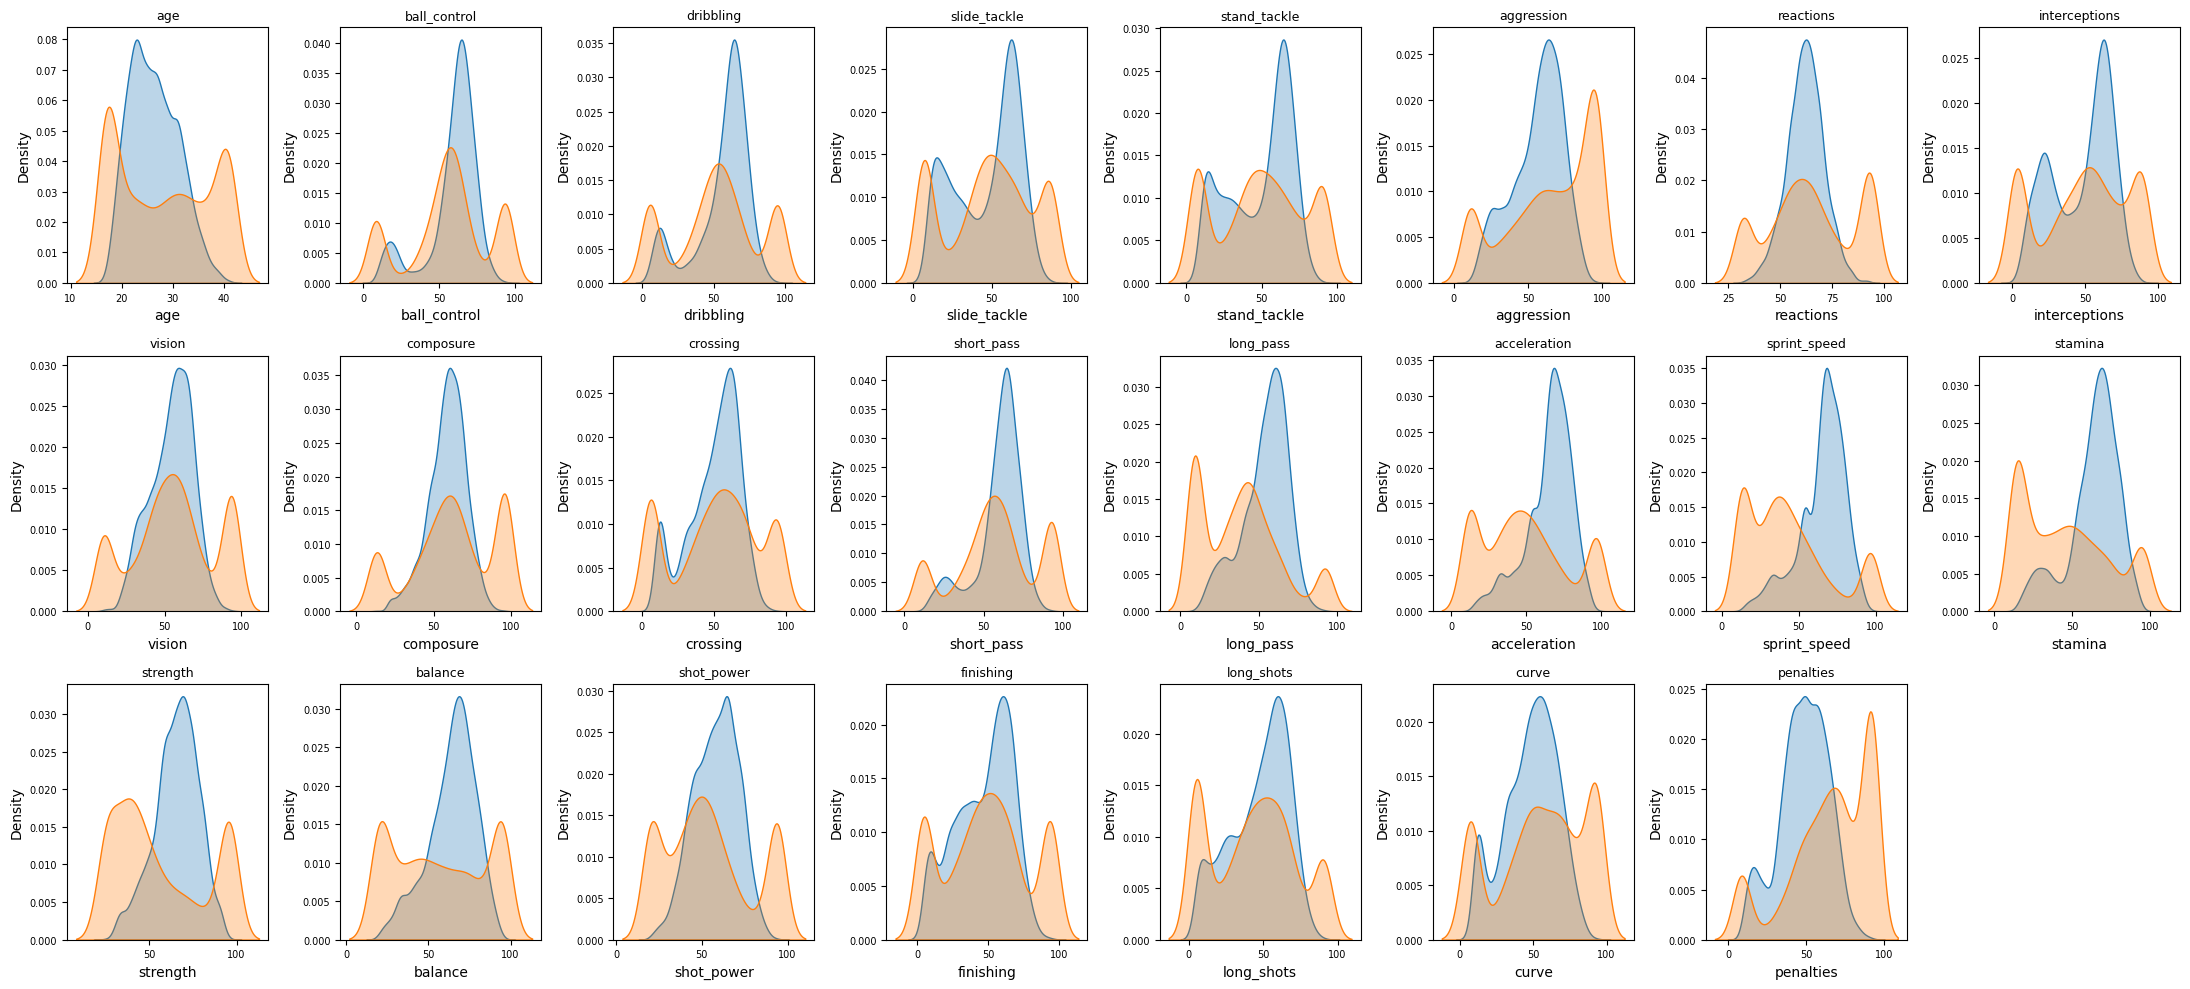

,Real Mean,Fake Mean,Real Std,Fake Std
age,26.320000,28.160000,4.730000,9.000000
ball_control,58.910000,55.930000,16.570000,26.500000
dribbling,56.130001,51.590000,18.770000,29.000000
slide_tackle,46.730000,47.830002,20.520000,27.209999
stand_tackle,48.820000,49.009998,20.980000,28.590000
aggression,56.320000,65.220001,16.850000,29.080000
reactions,61.959999,64.720001,8.890000,20.389999
interceptions,47.389999,48.169998,20.450001,29.820000
vision,54.470001,55.480000,13.710000,26.639999
composure,58.619999,61.880001,12.020000,26.700001


,Feature,WassersteinDistance
0,age,4.322546
3,slide_tackle,6.581625
4,stand_tackle,7.666895
19,finishing,8.081175
7,interceptions,8.180319
20,long_shots,8.946250
6,reactions,10.102157
10,crossing,10.178012
11,short_pass,10.502078
8,vision,10.534369


/tmp/ipython-input-2392597231.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


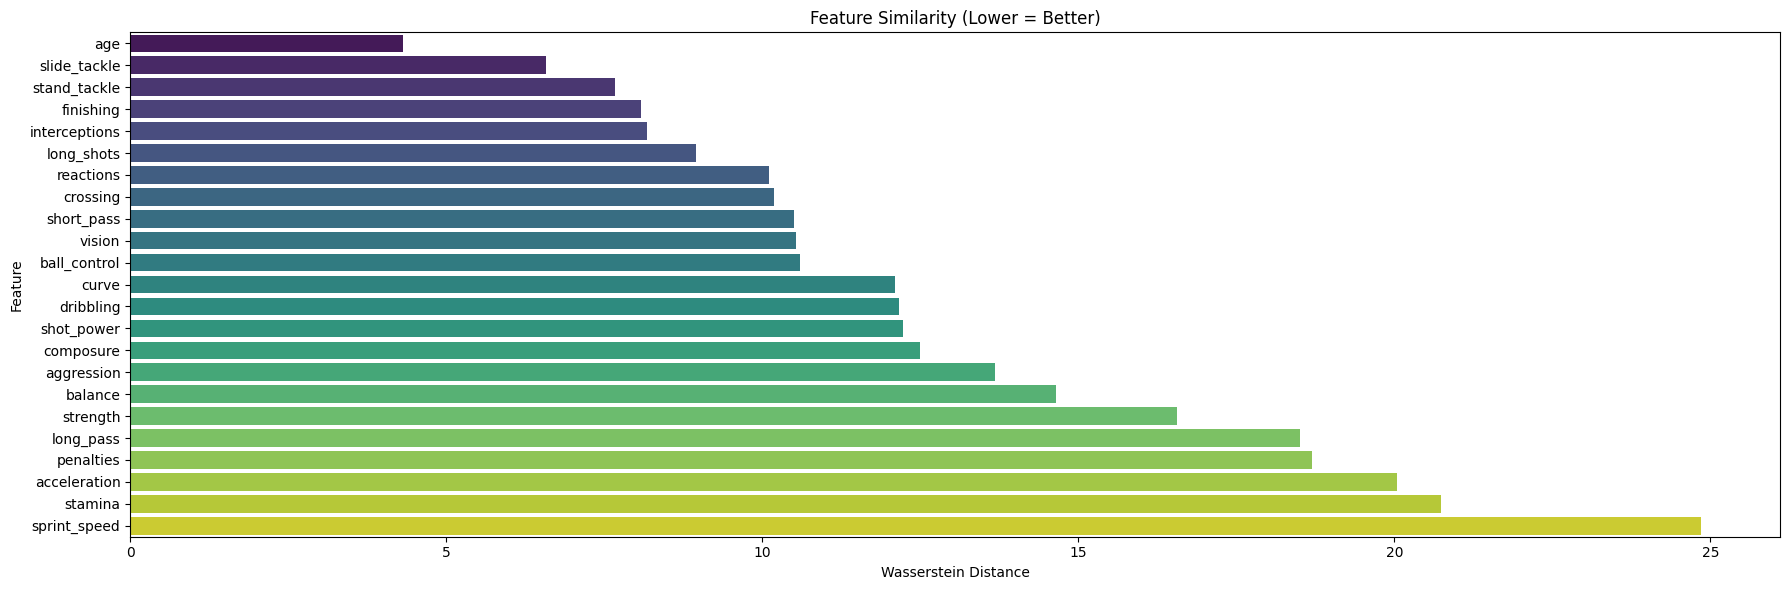

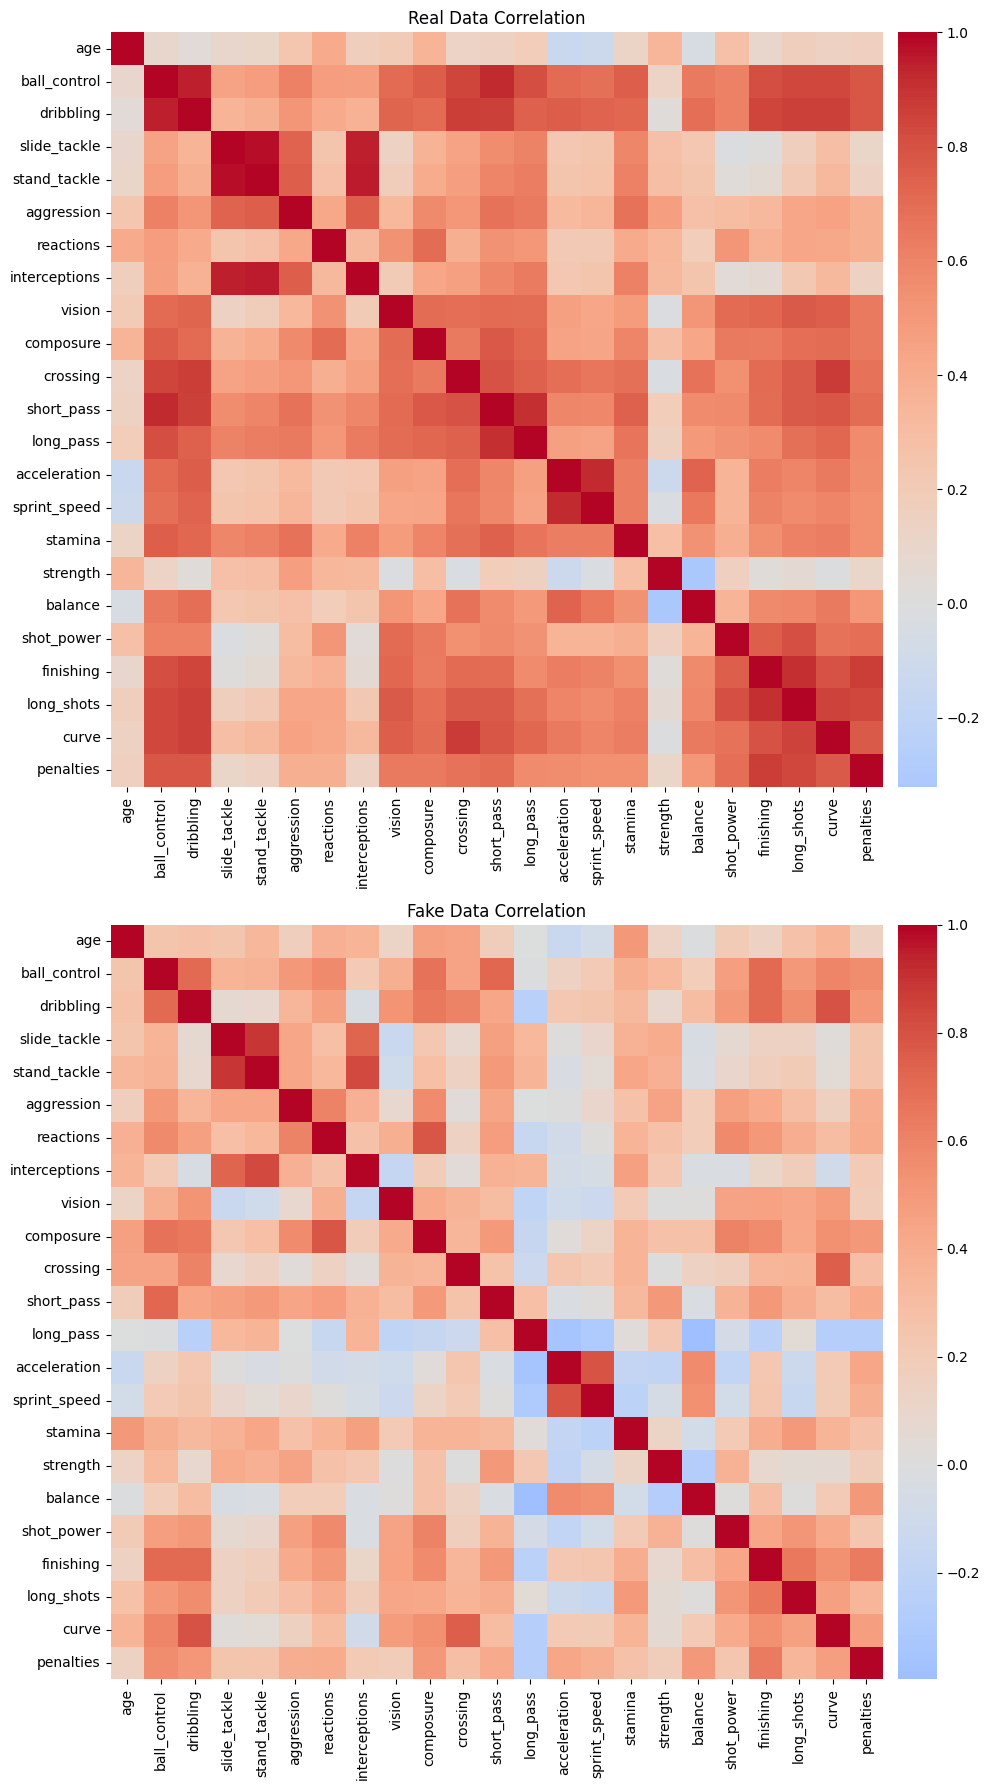

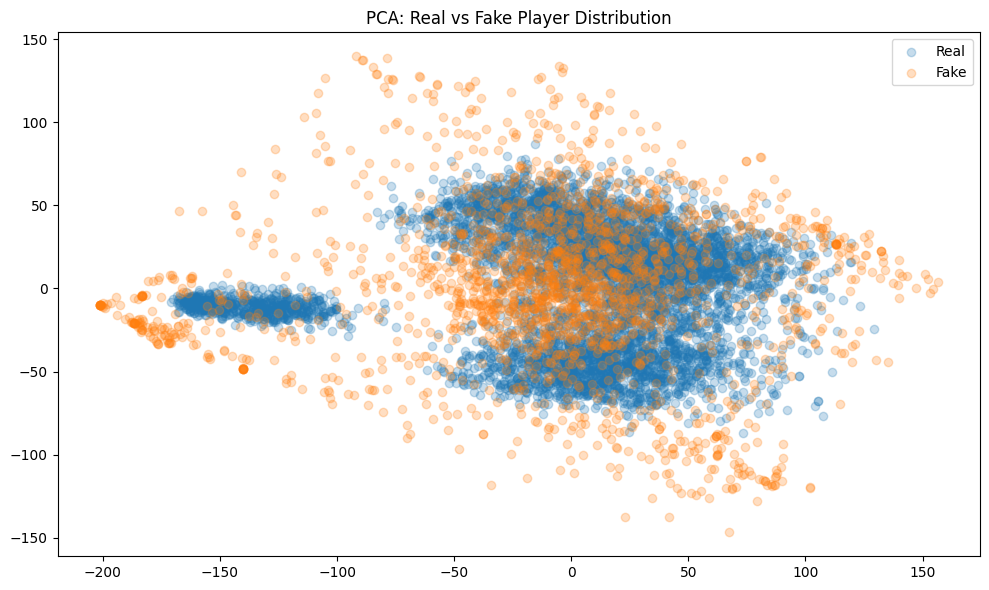

In [10]:
# Evaluation

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from sklearn.decomposition import PCA
import numpy as np


# KDE Distribution Comparison
features = df.columns.tolist()
rows = 3
cols = 8  # wide layout for slide readability

plt.figure(figsize=(22, 10))

for i, col in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    sns.kdeplot(real_df[col], label="Real", fill=True, alpha=0.3)
    sns.kdeplot(fake_df[col], label="Fake", fill=True, alpha=0.3)
    plt.title(col, fontsize=9)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

plt.tight_layout()
plt.savefig(output_path + "kde_all_features.png", dpi=300)
plt.show()

# Summary Statistics Table
compare_stats = pd.DataFrame({
    "Real Mean": real_df.mean(),
    "Fake Mean": fake_df.mean(),
    "Real Std": real_df.std(),
    "Fake Std": fake_df.std()
}).round(2)

display(compare_stats)
compare_stats.to_csv(output_path + "summary_stats.csv", index=False)


# Wasserstein Distances
distances = {
    col: wasserstein_distance(real_df[col], fake_df[col])
    for col in df.columns
}

wd_df = pd.DataFrame(
    distances.items(),
    columns=["Feature", "WassersteinDistance"]
).sort_values("WassersteinDistance")

display(wd_df)
wd_df.to_csv(output_path + "wasserstein_distances.csv", index=False)


# Horizontal Wasserstein Bar Plot
plt.figure(figsize=(18, 6))
sns.barplot(
    data=wd_df,
    y="Feature",
    x="WassersteinDistance",
    palette="viridis",
    orient="h"
)

plt.title("Feature Similarity (Lower = Better)")
plt.xlabel("Wasserstein Distance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(output_path + "wasserstein_barplot.png", dpi=300)
plt.show()



# Rotated Correlation Heatmaps
import matplotlib.pyplot as plt
import seaborn as sns

corr_real = real_df.corr()
corr_fake = fake_df.corr()

fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(10, 18),  # tall figure
    gridspec_kw={'width_ratios': [1, 0.05]}  # right column = thin colorbars
)


# REAL DATA HEATMAP
ax_real = axes[0,0]
cbar_real = axes[0,1]  # dedicated small axis for colorbar

sns.heatmap(
    corr_real,
    cmap="coolwarm",
    center=0,
    cbar=True,
    cbar_ax=cbar_real,   # ensures identical height
    ax=ax_real
)

ax_real.set_title("Real Data Correlation")


# FAKE DATA HEATMAP
ax_fake = axes[1,0]
cbar_fake = axes[1,1]  # dedicated small axis for colorbar

sns.heatmap(
    corr_fake,
    cmap="coolwarm",
    center=0,
    cbar=True,
    cbar_ax=cbar_fake,   # ensures identical height
    ax=ax_fake
)

ax_fake.set_title("Fake Data Correlation")



# Final layout
plt.tight_layout()
plt.savefig(output_path + "correlation_heatmaps.png", dpi=300)
plt.show()


# PCA Visualization
pca = PCA(n_components=2)
pca_real = pca.fit_transform(real_df)
pca_fake = pca.transform(fake_df)

plt.figure(figsize=(10, 6))
plt.scatter(pca_real[:, 0], pca_real[:, 1], alpha=0.25, label="Real")
plt.scatter(pca_fake[:, 0], pca_fake[:, 1], alpha=0.25, label="Fake")
plt.legend()
plt.title("PCA: Real vs Fake Player Distribution")
plt.tight_layout()
plt.savefig(output_path + "pca_real_vs_fake.png", dpi=300)
plt.show()
